In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from lifelines import CoxPHFitter
import numpy as np
from lifelines import KaplanMeierFitter

In [25]:
df = pd.read_csv('relations_minified_versioning.csv')

## Data Preprocessing
df['is_out_of_date'] = df['is_out_of_date'].map({'t': True, 'f': False})
df['is_exposed'] = df['is_exposed'].map({'t': True, 'f': False})
df['interval_start_days'] = pd.to_numeric(df['interval_start_days'], errors='coerce')
df = df.dropna(subset=['interval_start_days'])
df['interval_end_days'] = pd.to_numeric(df['interval_end_days'], errors='coerce') ##coerce the errors to drop /N (NA) value in data
df = df.dropna(subset=['interval_end_days'])

df.dtypes

df.head

df.requirement_type.unique()

array(['floating - minor', 'floating - major', 'pinned', 'other',
       'floating - patch', 'floating - major - restrictive'], dtype=object)

In [ ]:
# Need to convert the requirement_type column to a categorical type
## I can't tell if this is correct because the floating - major gets dropped 

df['requirement_type'] = pd.Categorical(
    df['requirement_type'],
    categories=[
        'floating - major', # This is the baseline category for one-hot encoding
        'floating - major - restrictive',
        'floating - minor',
        'floating - patch',
        'pinned',
        'other'
    ],
    ordered=True
)
df = pd.get_dummies(df, columns=['requirement_type'], drop_first=True)

# Sorting has effect on the model since the model expects the data for each individual together
df.sort_values(by=['dependency_id', 'interval_start_days', 'interval_end_days'], inplace=True)

,dependency_id,interval_start_days,interval_end_days,is_out_of_date,is_exposed,requirement_type_floating - major - restrictive,requirement_type_floating - minor,requirement_type_floating - patch,requirement_type_pinned,requirement_type_other
617666,14,0,1.0,True,False,False,False,False,True,False
617667,14,1,2.0,True,False,False,False,False,True,False
617671,14,2,5.0,True,False,False,False,False,True,False
617669,14,5,5.0,True,False,False,False,False,True,False
617660,14,5,10.0,True,False,False,False,False,True,False


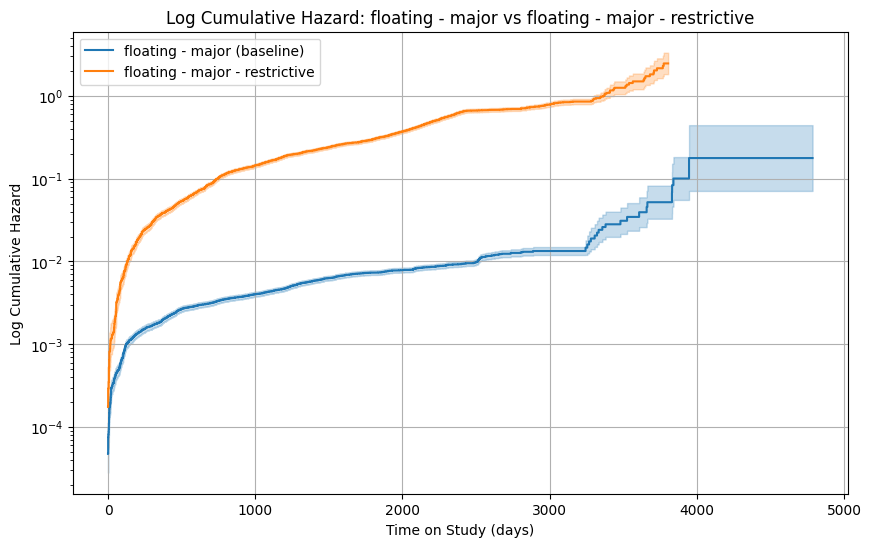

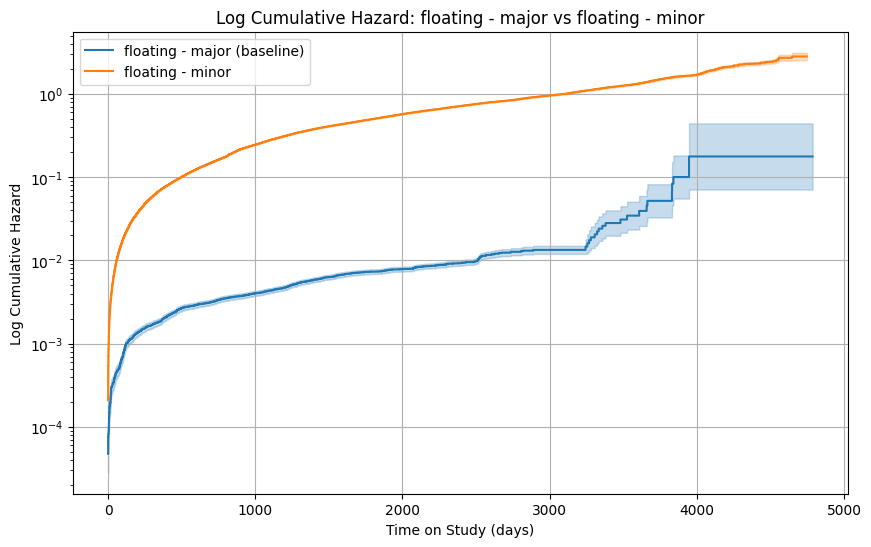

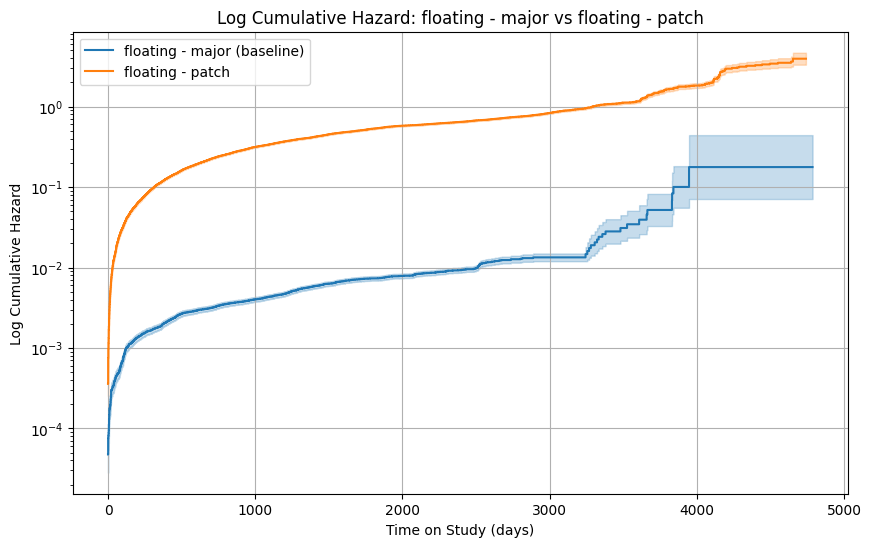

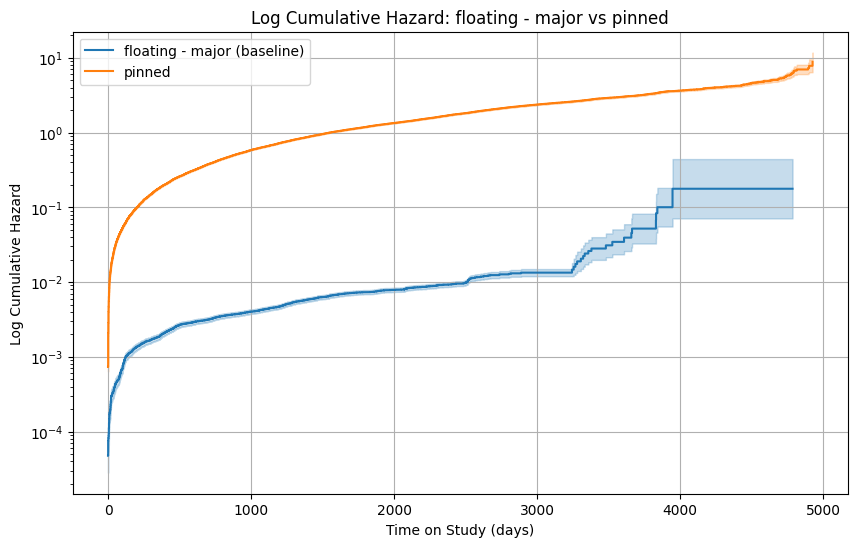

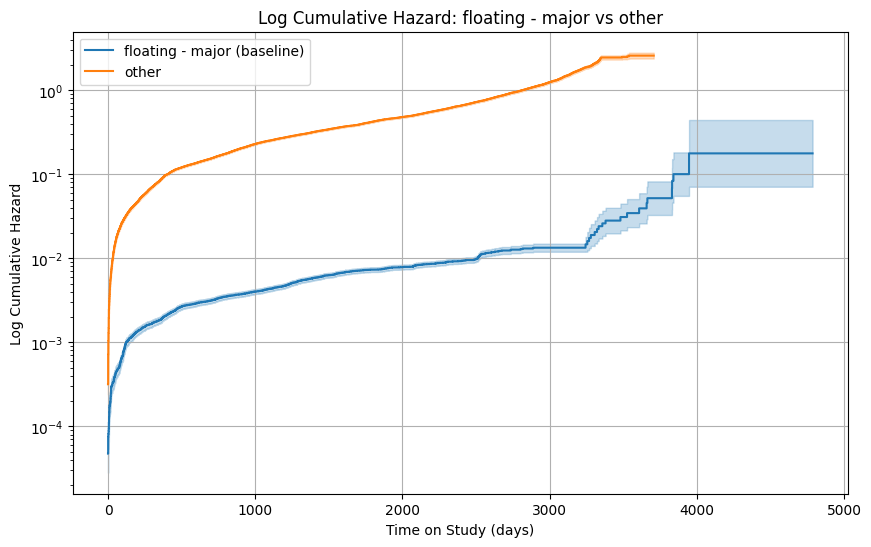

In [ ]:
# Create log-cumulative hazard plots for each category vs the baseline
for category in requirement_categories[1:]:  # Skip the baseline category
    # Create two groups - baseline and current category
    baseline = df_original[df_original['requirement_type'] == 'floating - major']
    current = df_original[df_original['requirement_type'] == category]
    
    # Make sure we have enough data in both groups
    if len(baseline) < 5 or len(current) < 5:
        print(f"Skipping {category} - not enough data")
        continue
    
    # Fit Nelson-Aalen for each group
    naf_base = NelsonAalenFitter()
    naf_current = NelsonAalenFitter()
    
    naf_base.fit(baseline['interval_end_days'], baseline['is_out_of_date'], label='floating - major (baseline)')
    naf_current.fit(current['interval_end_days'], current['is_out_of_date'], label=category)
    
    # Create log-log plot (log cumulative hazard)
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    
    # Plot log cumulative hazard
    naf_base.plot(ax=ax, logx=False, logy=True)
    naf_current.plot(ax=ax, logx=False, logy=True)
    
    plt.title(f'Log Cumulative Hazard: floating - major vs {category}')
    plt.xlabel('Time on Study (days)')
    plt.ylabel('Log Cumulative Hazard')
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
## Based on the plots above, the assumption of proportional hazards seems to be violated. Thus, we can confirm we need to use a time-varying covariate model.